In [ ]:
# ! pip install wandb

In [ ]:

import time
import torch
import math
import argparse
import os
import json
import torch.nn as nn
import torch.nn.functional as F


In [ ]:

parser = argparse.ArgumentParser()
parser.add_argument('--no_cuda', action='store_true', default=False, help='disables CUDA training (eg. no nvidia GPU)')
parser.add_argument('--epochs', type=int, default=1000, help='number of epochs to train')
# model parameters
parser.add_argument('--model', type=str, default='softbox', help='model type: choose from softbox, gumbel')
parser.add_argument('--box_embedding_dim', type=int, default=40, help='box embedding dimension')
parser.add_argument('--softplus_temp', type=float, default=1.0, help='beta of softplus function')
# gumbel box parameters
parser.add_argument('--gumbel_beta', type=float, default=1.0, help='beta value for gumbel distribution')
parser.add_argument('--scale', type=float, default=1.0, help='scale value for gumbel distribution')

parser.add_argument('--dataset', type=str, default='GALEN', help='dataset')
parser.add_argument('--using_rbox', type=int, default=1, help='using_rbox')
parser.add_argument('--gpu', type=int, default=0, help='gpu')

parser.add_argument('--dimension', type=int, default=50, help='dimension')
parser.add_argument('--learning_rate', type=int, default=0.001, help='learning_rate')
parser.add_argument('--batch_size', type=int, default=256, help='batch_size')
parser.add_argument('--seed', type=int, default=1111, help='seed')

args = parser.parse_args(args=['--no_cuda'] )
args.save_to = "./checkpoints/" + args.model

gpu = args.gpu
dimension = args.dimension
learning_rate = args.learning_rate
batch_size = args.batch_size
seed = args.seed
dataset = args.dataset
using_rbox = args.using_rbox
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'


In [ ]:

import time
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import uniform

eps = 1e-8

def l2_side_regularizer(box, log_scale: bool = True):
    """Applies l2 regularization on all sides of all boxes and returns the sum.
    """
    min_x = box.min_embed 
    delta_x = box.delta_embed  

    if not log_scale:
        return torch.mean(delta_x ** 2)
    else:
        return torch.mean(F.relu(min_x + delta_x - 1 + eps )) +  torch.mean(F.relu(-min_x - eps)) #+ F.relu(torch.norm(min_x, p=2)-1)

class Box:
    def __init__(self, min_embed, max_embed):
        self.min_embed = min_embed
        self.max_embed = max_embed
        self.delta_embed = max_embed - min_embed
        
class BoxEL(nn.Module):
    def __init__(self, entity_size, vocab_size, relation_size, embed_dim, min_init_value, delta_init_value, relation_init_value, scaling_init_value, args):
        super(BoxEL, self).__init__()
        min_embedding = self.init_concept_embedding(vocab_size, embed_dim, min_init_value)
        delta_embedding = self.init_concept_embedding(vocab_size, embed_dim, delta_init_value)
        relation_embedding = self.init_concept_embedding(relation_size, embed_dim, relation_init_value)
        scaling_embedding = self.init_concept_embedding(relation_size, embed_dim, scaling_init_value)
#         
        self.temperature = args.softplus_temp
        self.min_embedding = nn.Parameter(min_embedding)
        self.delta_embedding = nn.Parameter(delta_embedding)
        self.relation_embedding = nn.Parameter(relation_embedding)
        self.scaling_embedding = nn.Parameter(scaling_embedding)
        self.min_embedding = nn.Parameter(min_embedding)
        self.entity_embedding = nn.Parameter( self.init_concept_embedding(entity_size, embed_dim, min_init_value) )
        
        self.gumbel_beta = args.gumbel_beta
        self.scale = args.scale

    def forward(self, data):
        # ABox concept assertion
        points = self.entity_embedding[train_data[0][:,0]]
        nf1_min = self.min_embedding[data[0][:,1:]]
        nf1_delta = self.delta_embedding[data[0][:,1:]]
        nf1_max = nf1_min+torch.exp(nf1_delta)
        boxes = Box(nf1_min[:, 0, :], nf1_max[:, 0, :])
        concept_assertion_loss, ca_reg = self.concept_assertion_loss(points, boxes)
        # ABox role assertion
        points1= self.entity_embedding[train_data[1][:,0]]
        points2 = self.entity_embedding[train_data[1][:,2]]
        relation = self.relation_embedding[data[1][:,1]]
        scaling = self.scaling_embedding[data[1][:,1]]
        role_assertion_loss = self.role_assertion_loss(points1, relation, scaling, points2)
        
        # TBox nf1
        nf1_min = self.min_embedding[data[2][:,[0,2]]]
        nf1_delta = self.delta_embedding[data[2][:,[0,2]]]
        nf1_max = nf1_min+torch.exp(nf1_delta)
        boxes1 = Box(nf1_min[:, 0, :], nf1_max[:, 0, :])
        boxes2 = Box(nf1_min[:, 1, :], nf1_max[:, 1, :])
        nf1_loss, nf1_reg_loss = self.nf1_loss(boxes1, boxes2)
         # TBox nf2
        nf2_min = self.min_embedding[data[3]]
        nf2_delta = self.delta_embedding[data[3]]
        nf2_max = nf2_min+torch.exp(nf2_delta)
        boxes1 = Box(nf2_min[:, 0, :], nf2_max[:, 0, :])
        boxes2 = Box(nf2_min[:, 1, :], nf2_max[:, 1, :])
        boxes3 = Box(nf2_min[:, 2, :], nf2_max[:, 2, :])
        nf2_loss,nf2_reg_loss = self.nf2_loss(boxes1, boxes2, boxes3)
         # TBox nf3
        nf3_min = self.min_embedding[data[4][:,[0,2]]]
        nf3_delta = self.delta_embedding[data[4][:,[0,2]]]
        nf3_max = nf3_min+torch.exp(nf3_delta)
        relation = self.relation_embedding[data[4][:,1]]
        scaling = self.scaling_embedding[data[4][:,1]]
        boxes1 = Box(nf3_min[:, 0, :], nf3_max[:, 0, :])
        boxes2 = Box(nf3_min[:, 1, :], nf3_max[:, 1, :])
        nf3_loss,nf3_reg_loss = self.nf3_loss(boxes1, relation, scaling, boxes2)
         # TBox nf4
        nf4_min = self.min_embedding[data[5][:,1:]]
        nf4_delta = self.delta_embedding[data[5][:,1:]]
        nf4_max = nf4_min+torch.exp(nf4_delta)
        relation = self.relation_embedding[data[5][:,0]]
        scaling = self.scaling_embedding[data[5][:,0]]
        boxes1 = Box(nf4_min[:, 0, :], nf4_max[:, 0, :])
        boxes2 = Box(nf4_min[:, 1, :], nf4_max[:, 1, :])
        nf4_loss,nf4_reg_loss = self.nf4_loss(relation, scaling, boxes1, boxes2)
         # TBox disjoint
        disjoint_min = self.min_embedding[data[6]]
        disjoint_delta = self.delta_embedding[data[6]]
        disjoint_max = disjoint_min+torch.exp(disjoint_delta)
        boxes1 = Box(disjoint_min[:, 0, :], disjoint_max[:, 0, :])
        boxes2 = Box(disjoint_min[:, 1, :], disjoint_max[:, 1, :])
        disjoint_loss,disjoint_reg_loss = self.disjoint_loss(boxes1, boxes2)
        # TBox nf1_neg
        nf1_neg_min = self.min_embedding[data[7][:,[0,2]]]
        nf1_neg_delta = self.delta_embedding[data[7][:,[0,2]]]
        nf1_neg_max = nf1_neg_min+torch.exp(nf1_neg_delta)
        boxes1 = Box(nf1_neg_min[:, 0, :], nf1_neg_max[:, 0, :])
        boxes2 = Box(nf1_neg_min[:, 1, :], nf1_neg_max[:, 1, :])
        nf1_neg_loss, nf1_neg_reg_loss = self.nf1_loss(boxes1, boxes2)
        nf1_neg_loss = 1 - nf1_neg_loss

        return concept_assertion_loss.sum(), role_assertion_loss.sum(), nf1_loss.sum(), nf1_neg_loss.sum(), nf2_loss.sum(), nf3_loss.sum(), nf4_loss.sum(), disjoint_loss.sum(), nf1_reg_loss, nf1_neg_reg_loss, nf2_reg_loss , nf3_reg_loss , nf4_reg_loss, disjoint_reg_loss

    def concept_assertion_loss(self, points, boxes):
        concept_assertion_loss = torch.norm(F.relu(points - boxes.max_embed + eps), p=2, dim=1,keepdim=True) + torch.norm(F.relu( boxes.min_embed  - points -eps), p=2, dim=1,keepdim=True)
        return concept_assertion_loss, l2_side_regularizer(boxes, log_scale=True) 

    def role_assertion_loss(self, points1, relation, scaling, points2):
        trans_point = points1*scaling+relation
        role_assertion_loss = torch.norm(trans_point-points2,p=2, dim=1,keepdim=True)
        return role_assertion_loss

    def get_cond_probs(self, data):
        nf3_min = self.min_embedding[data[:,[0,2]]]
        nf3_delta = self.delta_embedding[data[:,[0,2]]]
        nf3_max = nf3_min+torch.exp(nf3_delta)
        relation = self.relation_embedding[data[:,1]]
        boxes1 = Box(nf3_min[:, 0, :], nf3_max[:, 0, :])
        boxes2 = Box(nf3_min[:, 1, :], nf3_max[:, 1, :])
        log_intersection = torch.log(torch.clamp(self.volumes(self.intersection(boxes1, boxes2)), 1e-10, 1e4))
        log_box2 = torch.log(torch.clamp(self.volumes(boxes2), 1e-10, 1e4))
        return torch.exp(log_intersection-log_box2)

    def volumes(self, boxes):
        return F.softplus(boxes.delta_embed, beta=self.temperature).prod(1)

    def intersection(self, boxes1, boxes2):
        intersections_min = torch.max(boxes1.min_embed, boxes2.min_embed)
        intersections_max = torch.min(boxes1.max_embed, boxes2.max_embed)
        intersection_box = Box(intersections_min, intersections_max)
        return intersection_box
    
    def inclusion_loss(self, boxes1, boxes2):
        log_intersection = torch.log(torch.clamp(self.volumes(self.intersection(boxes1, boxes2)), 1e-10, 1e4))
        log_box1 = torch.log(torch.clamp(self.volumes(boxes1), 1e-10, 1e4))
        return 1-torch.exp(log_intersection-log_box1)
    
    def nf1_loss(self, boxes1, boxes2):
        return self.inclusion_loss(boxes1, boxes2), l2_side_regularizer(boxes1, log_scale=True) + l2_side_regularizer(boxes2, log_scale=True)
        
    def nf2_loss(self, boxes1, boxes2, boxes3):
        inter_box = self.intersection(boxes1, boxes2)
        return self.inclusion_loss(inter_box, boxes3), l2_side_regularizer(inter_box, log_scale=True) + l2_side_regularizer(boxes1, log_scale=True) + l2_side_regularizer(boxes2, log_scale=True) + l2_side_regularizer(boxes3, log_scale=True)
    
    def nf3_loss(self, boxes1, relation, scaling, boxes2):
        trans_min = boxes1.min_embed*(scaling + eps) + relation
        trans_max = boxes1.max_embed*(scaling + eps) + relation
        trans_boxes = Box(trans_min, trans_max)
        return self.inclusion_loss(trans_boxes, boxes2), l2_side_regularizer(trans_boxes, log_scale=True) + l2_side_regularizer(boxes1, log_scale=True) + l2_side_regularizer(boxes2, log_scale=True) 
    
    def nf4_loss(self, relation, scaling, boxes1, boxes2):
        trans_min = (boxes1.min_embed - relation)/(scaling + eps)
        trans_max = (boxes1.max_embed - relation)/(scaling + eps)
        trans_boxes = Box(trans_min, trans_max)
        return self.inclusion_loss(trans_boxes, boxes2), l2_side_regularizer(trans_boxes, log_scale=True) + l2_side_regularizer(boxes1, log_scale=True) + l2_side_regularizer(boxes2, log_scale=True) 
        
    def disjoint_loss(self, boxes1, boxes2):
        log_intersection = torch.log(torch.clamp(self.volumes(self.intersection(boxes1, boxes2)), 1e-10, 1e4))
        log_boxes1 = torch.log(torch.clamp(self.volumes(boxes1), 1e-10, 1e4))
        log_boxes2 = torch.log(torch.clamp(self.volumes(boxes2), 1e-10, 1e4))
        union = log_boxes1 + log_boxes2
        return torch.exp(log_intersection-union), l2_side_regularizer(boxes1, log_scale=True) + l2_side_regularizer(boxes2, log_scale=True)
        
    def role_inclusion_loss(self, translation_1,translation_2,scaling_1,scaling_2):
        loss_1 = torch.norm(translation_1-translation_2, p=2, dim=1,keepdim=True)
        loss_2 = torch.norm(F.relu(scaling_1/(scaling_2 +eps) -1), p=2, dim=1,keepdim=True)
        return loss_1+loss_2
    
    def role_chain_loss(self, translation_1,translation_2,translation_3,scaling_1,scaling_2,scaling_3):
        loss_1 = torch.norm(scaling_1*translation_1 + translation_2 -translation_3, p=2, dim=1,keepdim=True)
        loss_2 = torch.norm(F.relu(scaling_1*scaling_2/(scaling_3 +eps) -1), p=2, dim=1,keepdim=True)
        return loss_1+loss_2
    
    def init_concept_embedding(self, vocab_size, embed_dim, init_value):
        distribution = uniform.Uniform(init_value[0], init_value[1])
        box_embed = distribution.sample((vocab_size, embed_dim))
        return box_embed




In [ ]:


train_data = []
# ABox
train_data.append(torch.Tensor([[0,4],[1,4],[2,5],[3,5]]).long().to(device)) # concept assertion
train_data.append(torch.Tensor([[0,1,2],[3,2,1]]).long().to(device)) # role assertion
# Tbox
train_data.append(torch.Tensor([[1,0,0],[2,0,0],[3,0,0],[4,0,1],[4,0,2],[5,0,2],[5,0,3]]).long().to(device)) #nf1 c in d
train_data.append(torch.Tensor([[1,2,4],[2,3,5]]).long().to(device)) # nf2
train_data.append(torch.Tensor([[2,0,0]]).long().to(device)) # nf3
train_data.append(torch.Tensor([[0,0,2]]).long().to(device)) #nf4
train_data.append(torch.Tensor([[1,3,0]]).long().to(device)) #disjoint
train_data.append(torch.Tensor([[2,0,5],[3,0,5],[1,0,4],[2,0,4]]).long().to(device)) # nf1 neg
train_data.append(torch.Tensor([[6]]).long().to(device)) #disjoint

#RBox
train_data.append(torch.Tensor([[1,0],[2,0]]).long().to(device)) 
train_data.append(torch.Tensor([[1,2,3],[1,2,3]]).long().to(device)) 

train_data



[tensor([[0, 4],
         [1, 4],
         [2, 5],
         [3, 5]]), tensor([[0, 1, 2],
         [3, 2, 1]]), tensor([[1, 0, 0],
         [2, 0, 0],
         [3, 0, 0],
         [4, 0, 1],
         [4, 0, 2],
         [5, 0, 2],
         [5, 0, 3]]), tensor([[1, 2, 4],
         [2, 3, 5]]), tensor([[2, 0, 0]]), tensor([[0, 0, 2]]), tensor([[1, 3, 0]]), tensor([[2, 0, 5],
         [3, 0, 5],
         [1, 0, 4],
         [2, 0, 4]]), tensor([[6]]), tensor([[1, 0],
         [2, 0]]), tensor([[1, 2, 3],
         [1, 2, 3]])]

In [ ]:
wandb.init(project="basic_box",  reinit=False, config=args)
# 

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
torch.manual_seed(888)
model = BoxEL(4, 6, 7, 2, [1e-4,0.2], [-0.1, 0], [-0.1,0.1], [0.9, 1.1], args).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model


BoxEL()

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

def plot_box(boxes, relation, scaling_emb, epoch, loss):
    clear_output(wait=True)
    plt.figure(figsize=(5,4))

#     plt.subplot(121)
    
    labels = ['Person','Male','Parent','Female','Father','Mother']
    color = ['r','b','g','purple','m','c']
    
    # Plot individual embedding
    x = model.entity_embedding.cpu().detach().numpy()[:,0]
    y = model.entity_embedding.cpu().detach().numpy()[:,1]
    label = ['Alex','Bob','Alice','Maria']
    plt.scatter(x,y,c=['r','m','lightgreen','darkblue'])
    for i, txt in enumerate(label):
        plt.annotate(txt, (x[i], y[i]))

    # Plot concept embedding
    for i in range(boxes.min_embed.shape[0]):
        x1,x2,w,h = boxes.min_embed[i][0].detach().numpy(),boxes.min_embed[i][1].detach().numpy(),boxes.max_embed[i][0].detach().numpy()-boxes.min_embed[i][0].detach().numpy(), boxes.max_embed[i][1].detach().numpy()-boxes.min_embed[i][1].detach().numpy()
        rect=mpatches.Rectangle((x1,x2),w,h, fill = False, color = color[i],linewidth = 2, alpha=0.6, facecolor=color[i])
        plt.gca().add_patch(rect)
        plt.text(x1+w-0.14,x2+h-0.05, labels[i], color = color[i])
        
    plt.xlim(-0.03,1.03)
    plt.ylim(-0.03,1.03)
    plt.savefig('toy_example.pdf', dpi=1200)
    
#     plt.title("Classes embedding")
#     x1,x2,w,h = boxes.min_embed[2][0],boxes.min_embed[2][1],boxes.max_embed[2][0]-boxes.min_embed[2][0], boxes.max_embed[2][1]-boxes.min_embed[2][1]
#     plt.arrow(x1.cpu().detach().numpy(), x2.cpu().detach().numpy(), rel_emb[0][0].cpu().detach().numpy(), rel_emb[0][1].cpu().detach().numpy(), head_width=0.01, head_length=0.01, fc='k', ec='k')
#     plt.text(x1 + rel_emb[0][0]/2, x2+rel_emb[0][1]/2, 'hasChild', color = 'black')
    
    
#     plt.subplot(122)
    
#     labels = ['Person','Male','Parent','Femal','Father','Mother']
#     color = ['r','b','g','purple','m','c']
    
#     # Plot individual embedding
#     x = model.entity_embedding.cpu().detach().numpy()[:,0]
#     y = model.entity_embedding.cpu().detach().numpy()[:,1]
#     label = ['Alex','Bob','Alice','Maria']
#     plt.scatter(x,y,c=['r','m','lightgreen','darkblue'])
#     for i, txt in enumerate(label):
#         plt.annotate(txt, (x[i], y[i]))
        
#     plt.arrow(x, y, rel_emb[0][0].cpu().detach().numpy(), rel_emb[0][1].cpu().detach().numpy(), head_width=0.01, head_length=0.01, fc='k', ec='k')
#     plt.text(x1 + rel_emb[0][0]/2, x2+rel_emb[0][1]/2, 'hasChild', color = 'black')
    
    
#     x1,x2,w,h = boxes.min_embed[2][0],boxes.min_embed[2][1],boxes.max_embed[2][0]-boxes.min_embed[2][0], boxes.max_embed[2][1]-boxes.min_embed[2][1]
#     rect=mpatches.Rectangle((x1,x2),w,h, fill = False, color = 'green', linewidth = 1, alpha=0.6)
#     plt.gca().add_patch(rect)
#     plt.text(x1, x2+0.9*h, 'Parent', color = 'green')

#     trans_min = boxes.min_embed[2:3] + rel_emb[0]
#     trans_max = trans_min + (boxes.max_embed[2:3] - boxes.min_embed[2:3])*scaling_emb[0]
    
    
#     x1,x2,w,h = trans_min[0][0],trans_min[0][1],trans_max[0][0]-trans_min[0][0], trans_max[0][1]-trans_min[0][1]
#     rect=mpatches.Rectangle((x1,x2),w,h, fill = False, color = 'orange', linewidth = 1, alpha=0.6)
#     plt.gca().add_patch(rect)
#     plt.text(x1, x2+0.9*h, 'Parent + hasChild ', color = 'orange')
    
#     x1,x2,w,h = boxes.min_embed[0][0],boxes.min_embed[0][1],boxes.max_embed[0][0]-boxes.min_embed[0][0], boxes.max_embed[0][1]-boxes.min_embed[0][1]
#     rect=mpatches.Rectangle((x1,x2),w,h, fill = False, color = 'red', linewidth = 1, alpha=0.6)
#     plt.gca().add_patch(rect)
#     plt.text(x1, x2+0.9*h, 'Person', color = 'red')
    
#     plt.xlim(-0.5,1)
#     plt.ylim(-0.5,1)
#     plt.title("Relation embedding")

    plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


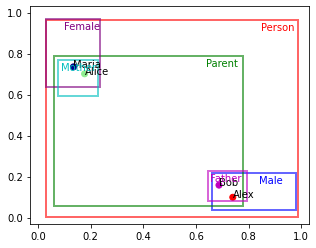

In [ ]:

model.train()
for epoch in range(400):
#     concept_assertion_loss, role_assertion_loss, nf1_loss, nf2_loss, nf3_loss, nf4_loss, disjoint_loss, nf3_neg_loss, role_inclusion_loss, role_chain_loss, concept_inclusion_reg_loss,nf1_reg_loss, nf2_reg_loss , nf3_reg_loss , nf4_reg_loss , disjoint_reg_loss , nf3_neg_reg_loss = 
    print(epoch)
    concept_assertion_loss, role_assertion_loss, nf1_loss, nf1_neg_loss, nf2_loss, nf3_loss, nf4_loss, disjoint_loss, nf1_reg_loss, nf1_neg_reg_loss, nf2_reg_loss , nf3_reg_loss , nf4_reg_loss, disjoint_reg_loss = model(train_data)
    loss =  concept_assertion_loss + role_assertion_loss + nf1_loss + nf1_reg_loss + nf2_loss + nf2_reg_loss + disjoint_loss + disjoint_reg_loss + nf3_loss + nf3_reg_loss + nf4_loss + nf4_reg_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 399 ==0:
        min_emb, delta_emb, max_emb, rel_emb, scaling_emb = model.min_embedding, model.delta_embedding, model.min_embedding +torch.exp(model.delta_embedding), model.relation_embedding, model.scaling_embedding
        boxes = Box(min_emb, max_emb)
        plot_box(boxes, rel_emb.detach().numpy(), scaling_emb.detach().numpy(), epoch, loss.item())
#     if epoch % 10 == 0:
#         print(nf1_loss.item(), nf2_loss.item(), nf3_loss.item(), nf4_loss.item(), disjoint_loss.item(), nf3_neg_loss.item(), nf1_reg_loss.item(),nf3_reg_loss.item(), nf4_reg_loss.item() )   
        
        
